<div class="alert alert-block alert-danger">
    <b> Unraveling the cytoskeletal architecture of cancer cells: a novel computational approach to predict cell fate - CODE</b> 
    
 **7 - RESULTS ANALYSIS**
    
**Author**: Diogo Fróis Vieira
</div>

<div class="alert alert-block alert-info">
    
 **IMPORTS**
    
</div>

In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))
import pandas as pd
import numpy as np
import math
import pickle
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
from packageCYSK.importing import *
from packageCYSK.visualization import *


print('📚 All libraries successfully imported 📚')

📚 All libraries successfully imported 📚


<div class="alert alert-block alert-info">
    
 **DIRECTORIES**
    
</div>

In [2]:
# Define dataset folder.
folder      = os.path.dirname(os.getcwd()) + "\\Datasets\\Set 1-a-tubulin_Sofia"

# Import images from CYTO, NUCL and RGB folders.
options     = ["CYTO","NUCL","RGB"]

# Dictionary with keys "CYTO", "NUCL", "RGB".
data = init_import(folder,options)

# Import processed results
#ResultsDF = pd.read_pickle(folder + "\\ResultsDF_TEST_DONE.pkl")
ResultsDF = pd.read_pickle(folder + "\\ResultsDF_7_nov_24_totest.pkl")


>>> [CYTO] added.
>>> [NUCL] added.
>>> [RGB] added.


In [3]:
ResultsDF['LSF3D:Mat Scores'] = pd.read_pickle(folder + "\\rsmatscoresvector_9_jan_24.pkl")

In [3]:
sep = create_separate_DFs(ResultsDF,options=["FULL"])
FULL = sep["FULL"]

C:\Users\diogo\OneDrive - Universidade de Lisboa\Ambiente de Trabalho\CYSK_Workspace\packageCYSK\processing.py:1007: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res += [(prefix + " kurtosis",kurtosis(data_array))]
C:\Users\diogo\OneDrive - Universidade de Lisboa\Ambiente de Trabalho\CYSK_Workspace\packageCYSK\processing.py:1008: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res += [(prefix + " skewness",skew(data_array))]
C:\Users\diogo\OneDrive - Universidade de Lisboa\Ambiente de Trabalho\CYSK_Workspace\packageCYSK\processing.py:1007: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res += [(prefix + " kurtosis

<div class="alert alert-block alert-info">
    
 **INSTRUCTIONS**
    
</div>

**1.** Import a dataframe with results.

**2.** You can either analyze

- **OPTION 1:** select a specific cell from the dataframe 

- **OPTION 2:** and/or the whole dataset of cells (global analysis)

<div class="alert alert-block alert-info">
    
 **SELECT CELL**
    
</div>

In [4]:
def dropdown_cell_eventhandler(change):
    global cell
    cell = dropdown_image.value
    lab = ResultsDF.loc[cell]['Label']
    print('Cell ' + str(cell) + ' (' + str(lab) +') selected.')

dropdown_image = widgets.Dropdown(description =  'Select Cell:' , options = ['...'] + list(ResultsDF.index))
dropdown_image.observe(dropdown_cell_eventhandler, names='value')
display(dropdown_image)

Dropdown(description='Select Cell:', options=('...', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,…

Cell 964 (WT) selected.
Cell 892 (Mut394) selected.
Cell 790 (Mock) selected.
Cell 674 (No transfection) selected.
Cell 301 (Del38_46) selected.
Cell 184 (Mock) selected.
Cell 92 (Mut394) selected.
Cell 14 (Del38_46) selected.
Cell 5 (No transfection) selected.
Cell 9 (No transfection) selected.
Cell 20 (Del38_46) selected.
Cell 139 (Mut394) selected.
Cell 207 (Mock) selected.
Cell 302 (Del38_46) selected.
Cell 411 (No transfection) selected.
Cell 507 (WT) selected.


<div class="alert alert-block alert-info">
    
 **PLOT INTENSITY**
    
</div>

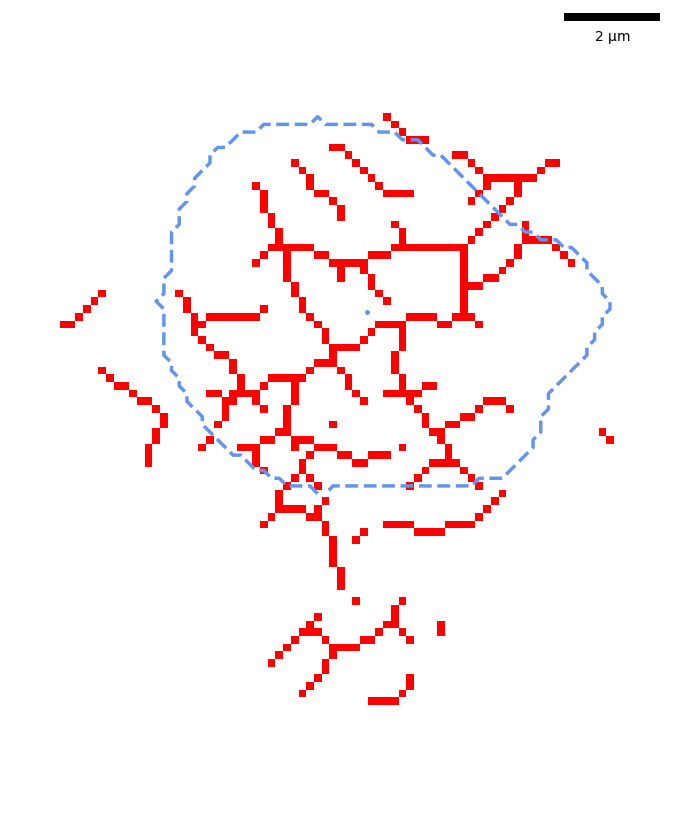

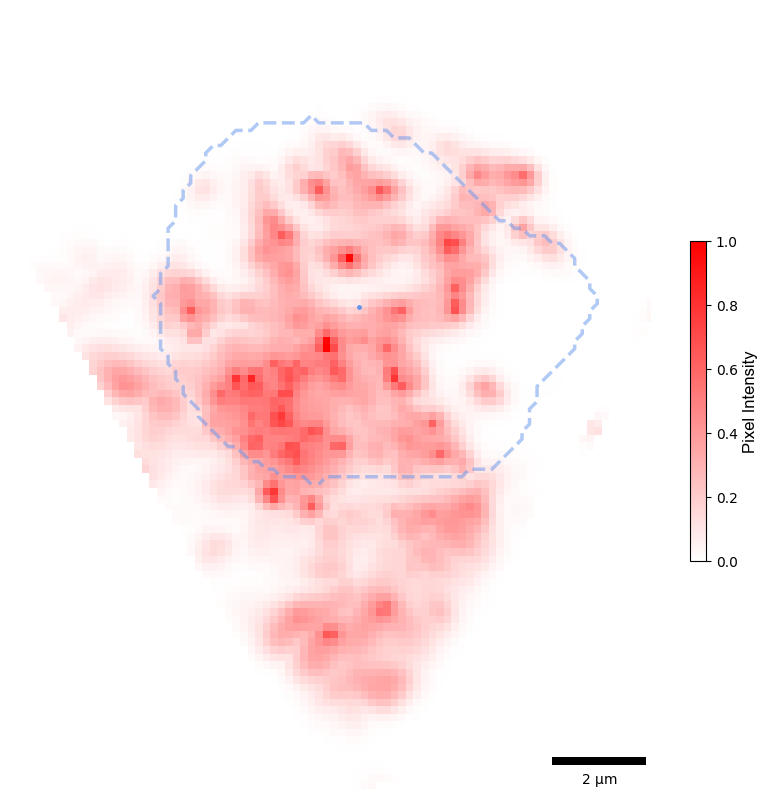

In [4]:
fig_sk,fig_int = intensity_plotter(ResultsRow = ResultsDF.loc[cell],
                                  data       = data,
                                  save       = False)   

<div class="alert alert-block alert-info">
    
 **PLOT LINES**
    
</div>

[104.0, 104.0]


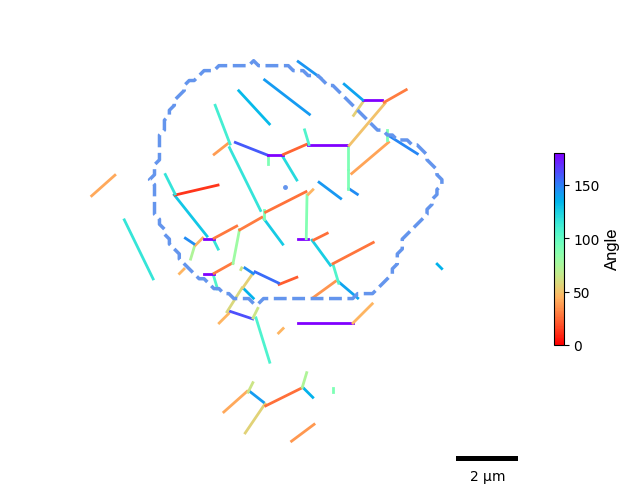

In [6]:
# PLOT LINES
%matplotlib inline

cmap     = pltc.rainbow_r
cm       = truncate_colormap(cmap, 0, 1, 300)

# ORIENTATION
fig_lines = line_plotter(ResultsRow = ResultsDF.loc[cell],
             data=data,
             feat='LSF2D:Theta (LinReg)',
             cmap=cm,
             normalize_bounds=[0, 180],
             colorbar_label='Angle',
             overlay=False,
             save='orientation_lines_exp')

# BUNDLING
# line_plotter(ResultsRow = ResultsDF.loc[cell],
#              data=data,
#              feat="LSF2D:Local Line Distance (LinReg)",
#              cmap=cm,
#              normalize_bounds=[0,4],
#              colorbar_label='Local Line Distance (µ)',
#              line_data_origin = 'Lines LinReg',
#              overlay=False,
#              save='bundling_lines0')

# PARALLELISM
# line_plotter(ResultsRow = ResultsDF.loc[cell],
#              data=data,
#              feat="LSF2D:Angle Difference (LinReg)",
#              cmap=cm,
#              normalize_bounds=[0,90],
#              colorbar_label='Mean Angle Difference (º)',
#              line_data_origin = 'Lines LinReg',
#              overlay=False,
#              save='parallelism_lines2')

# COMPACTNESS & QUANTITY
# line_plotter(ResultsRow = ResultsDF.loc[cell],
#              data=data,
#              feat=None,
#              cmap=cm,
#              normalize_bounds=None,
#              colorbar_label=None,
#              line_data_origin = 'Lines LinReg',
#              overlay=False,
#              save='compactness_lines1')

# RADIALITY
# line_plotter(ResultsRow = ResultsDF.loc[cell],
#              data=data,
#              feat="LSF2D:Alphas (LinReg)",
#              cmap=cm,
#              normalize_bounds=[0,90],
#              colorbar_label='Angle (º)',
#              line_data_origin = 'Lines LinReg',
#              overlay=False,
#              save=False)

# CYTO-NUC INTERACTION
# line_plotter(ResultsRow = ResultsDF.loc[cell],
#              data=data,
#              feat="LSF2D:Distances to Centroid (LinReg) (scaled)",
#              cmap=cm,
#              normalize_bounds=[0,30],
#              colorbar_label='Distance (μm)',
#              line_data_origin = 'Lines LinReg',
#              overlay=False,
#              save='cytonuc_lines0')

C:\Users\diogo\AppData\Local\Temp\ipykernel_5652\989134141.py:60: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Done.


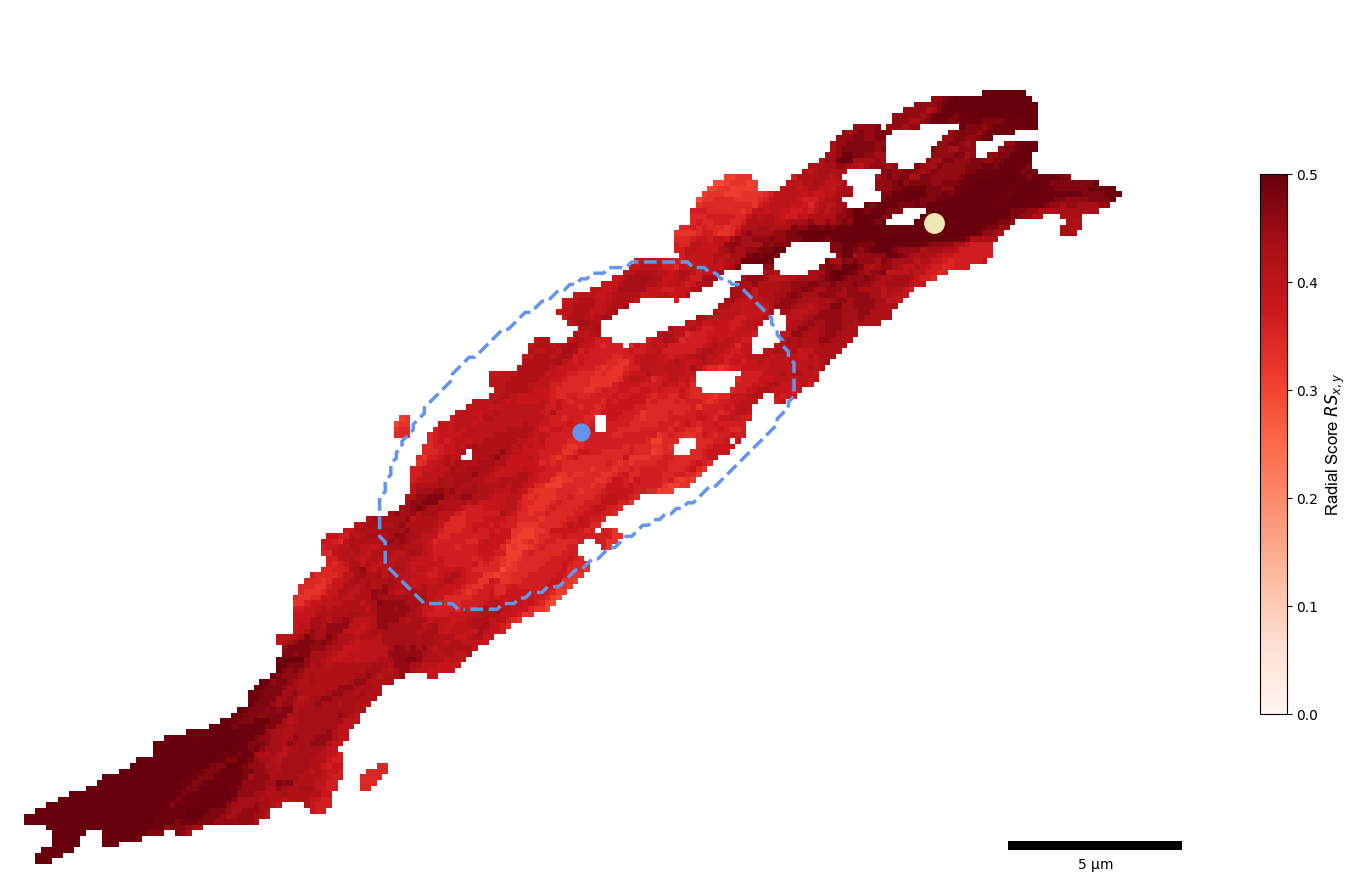

In [21]:
fig_rad = plot_radial(ResultsRow       = ResultsDF.loc[488], 
                      overlay          = None, 
                      normalize_bounds = 'default',
                      colorbar_label   = 'Radial Score $RS_{x,y}$',
                      save             = "RS2_map") 

<div class="alert alert-block alert-info">
    
 **PLOT GRAPH**
    
</div>

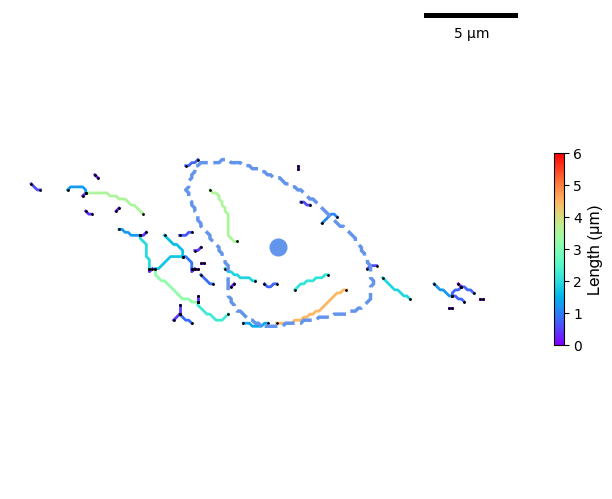

In [9]:
cmap     = pltc.rainbow
cm       = truncate_colormap(cmap, 0, 1, 300)

fig_graph = graph_plotter(ResultsRow       = ResultsDF.loc[cell],
                          data             = data,
                          feat             = 'SKNW:branch-distance (scaled)',
                          cmap             = cm,
                          normalize_bounds = [0,6],
                          colorbar_label   = 'Length (μm)',
                          nodes            = True,
                          main_branch      = False,
                          overlay          = None,
                          scalebar         = True,
                          save             = 'morphology_graph_fig4c')

# graph_plotter(ResultsRow       = ResultsDF.loc[cell],
#               data             = data,
#               feat             = 'CNF2D:Branch Orientation',
#               cmap             = cm,
#               normalize_bounds = [0,180],
#               colorbar_label   = 'Angle (º)',
#               nodes            = True,
#               main_branch      = False,
#               overlay          = None,
#               scalebar         = True,
#               save             = False)

# graph_plotter(ResultsRow       = ResultsDF.loc[cell],
#               data             = data,
#               feat             = 'CNF2D:Local Average Branch Distance',
#               cmap             = cm,
#               normalize_bounds = 'default',
#               colorbar_label   = 'Distance (μm)',
#               nodes            = False,
#               main_branch      = False,
#               overlay          = None,
#               scalebar         = True,
#               save             = False)

# graph_plotter(ResultsRow       = ResultsDF.loc[cell],
#               data             = data,
#               feat             = 'CNF2D:Mean Filament Thickness',
#               cmap             = cm,
#               normalize_bounds = [1,2],
#               colorbar_label   = 'Thickness (μm)',
#               nodes            = False,
#               main_branch      = False,
#               overlay          = None,
#               scalebar         = True,
#               save             = False)

# graph_plotter(ResultsRow       = ResultsDF.loc[cell],
#               data             = data,
#               feat             = 'CNF2D:Local Average Branch Orientation',
#               cmap             = cm,
#               normalize_bounds = 'default',
#               colorbar_label   = 'Angle (º)',
#               nodes            = False,
#               main_branch      = False,
#               overlay          = None,
#               scalebar         = True,
#               save             = False)

# graph_plotter(ResultsRow       = ResultsDF.loc[cell],
#               data             = data,
#               feat             = 'CNF2D:Local Average Bundling Score',
#               cmap             = cm,
#               normalize_bounds = 'default',
#               colorbar_label   = 'Distance * Angle (umº)',
#               nodes            = False,
#               main_branch      = False,
#               overlay          = None,
#               scalebar         = True,
#               save             = False)

# fig_graph = graph_plotter(ResultsRow       = ResultsDF.loc[cell],
#                           data             = data,
#                           feat             = 'CNF2D:Distances to Centroid',
#                           cmap             = cm,
#                           normalize_bounds = 'default',
#                           colorbar_label   = 'Distance (μm)',
#                           nodes            = False,
#                           main_branch      = False,
#                           overlay          = None,
#                           scalebar         = True,
#                           save             = False)

# fig_graph = graph_plotter(ResultsRow       = ResultsDF.loc[cell],
#               data             = data,
#               cmap             = cm,
#               feat             = None,
#               normalize_bounds = 'default',
#               colorbar_label   = None,
#               nodes            = True,
#               main_branch      = False,
#               overlay          = None,
#               scalebar         = True,
#               save             = 'figure4_graph')

# fig_graph = graph_plotter(ResultsRow       = ResultsDF.loc[cell],
#               data             = data,
#               feat             = 'branch-type',
#               cmap             = cm,
#               normalize_bounds = 'default',
#               colorbar_label   = None,
#               nodes            = True,
#               main_branch      = False,
#               overlay          = None,
#               scalebar         = True,
#               save             = 'connectivity2')

#graph_plotter(ResultsRow=ResultsDF.loc[cell],data=data,feat=None,cmap=cm,normalize_bounds='default',colorbar_label=None,nodes=True,main_branch=False, overlay = None,scalebar=False, save='preprocessing_cellX_paper_graph')

<div class="alert alert-block alert-info">
    
 **GLOBAL ANALYSIS**
    
</div>

Label
Del38_46           198
Dup41_46           155
Mock               202
Mut394             124
No transfection    190
WT                 177
Name: LSF1D:Circular Variance (LinReg), dtype: int64
                     Mean       Std   Std_Err
Label                                        
Del38_46         0.920519  0.048040  0.003414
Dup41_46         0.930233  0.038487  0.003091
Mock             0.905539  0.059924  0.004216
Mut394           0.906100  0.051804  0.004652
No transfection  0.913668  0.051154  0.003711
WT               0.871406  0.098935  0.007436
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Del38_46: Welch's t-test independent samples, P_val=6.868e-09 stat=-6.002e+00


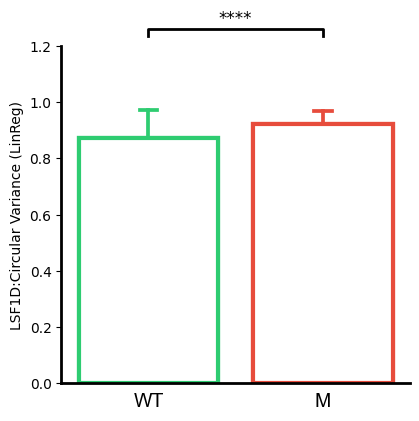

In [6]:
plot_barplot_paper(ResultsDF,
                   feature = [
                               
                               'LSF1D:Circular Variance (LinReg)'
                               
                              ])

Label
Del38_46           198
Dup41_46           155
Mock               202
Mut394             124
No transfection    190
WT                 177
Name: LSF1D:OOP (LinReg), dtype: int64
                     Mean       Std   Std_Err
Label                                        
Del38_46         0.079481  0.048040  0.003414
Dup41_46         0.069767  0.038487  0.003091
Mock             0.094461  0.059924  0.004216
Mut394           0.093900  0.051804  0.004652
No transfection  0.086332  0.051154  0.003711
WT               0.128594  0.098935  0.007436
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Del38_46: Welch's t-test independent samples, P_val=6.868e-09 stat=6.002e+00


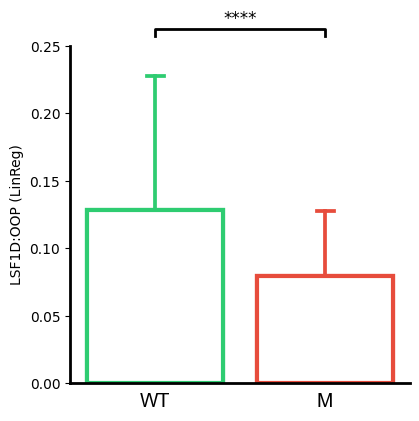

Label
Del38_46           198
Dup41_46           155
Mock               202
Mut394             124
No transfection    190
WT                 177
Name: LSF1D:Circular Variance (LinReg), dtype: int64
                     Mean       Std   Std_Err
Label                                        
Del38_46         0.920519  0.048040  0.003414
Dup41_46         0.930233  0.038487  0.003091
Mock             0.905539  0.059924  0.004216
Mut394           0.906100  0.051804  0.004652
No transfection  0.913668  0.051154  0.003711
WT               0.871406  0.098935  0.007436
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Del38_46: Welch's t-test independent samples, P_val=6.868e-09 stat=-6.002e+00


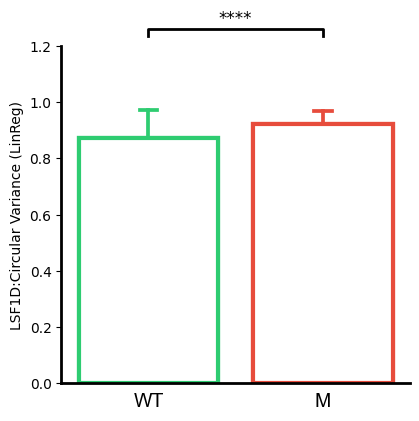

Label
Del38_46           198
Dup41_46           155
Mock               202
Mut394             124
No transfection    190
WT                 177
Name: SKNW:branch-distance (scaled) mean, dtype: int64
                     Mean       Std   Std_Err
Label                                        
Del38_46         1.023670  0.118302  0.008407
Dup41_46         1.011195  0.091961  0.007386
Mock             1.074065  0.148407  0.010442
Mut394           1.006441  0.104802  0.009411
No transfection  1.036373  0.115404  0.008372
WT               1.151957  0.196473  0.014768
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Del38_46: Welch's t-test independent samples, P_val=6.087e-13 stat=7.549e+00


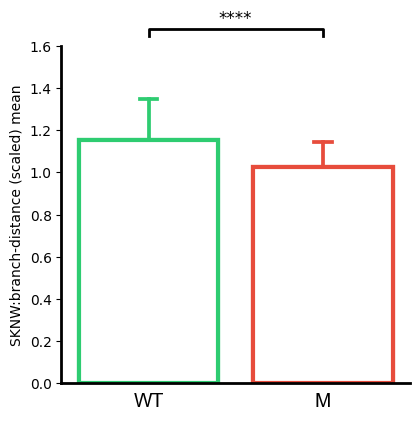

Label
Del38_46           198
Dup41_46           155
Mock               202
Mut394             124
No transfection    190
WT                 177
Name: SKNW:branch-distance (scaled) cv, dtype: int64
                     Mean       Std   Std_Err
Label                                        
Del38_46         0.824470  0.137939  0.009803
Dup41_46         0.828111  0.129582  0.010408
Mock             0.880246  0.152914  0.010759
Mut394           0.862895  0.118385  0.010631
No transfection  0.878381  0.153596  0.011143
WT               0.912204  0.159436  0.011984
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Del38_46: Welch's t-test independent samples, P_val=3.044e-08 stat=5.667e+00


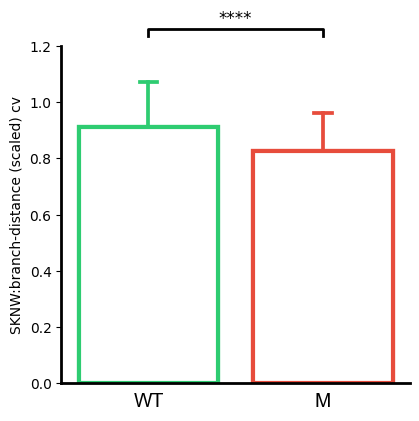

Label
Del38_46           198
Dup41_46           155
Mock               202
Mut394             124
No transfection    190
WT                 177
Name: LSF1D:N over A (LinReg), dtype: int64
                     Mean       Std   Std_Err
Label                                        
Del38_46         1.381324  0.356205  0.025314
Dup41_46         1.470359  0.224637  0.018043
Mock             1.626541  0.517069  0.036381
Mut394           1.466525  0.361264  0.032443
No transfection  1.449438  0.226729  0.016449
WT               1.045483  0.405742  0.030497
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Del38_46: Welch's t-test independent samples, P_val=6.570e-16 stat=-8.473e+00


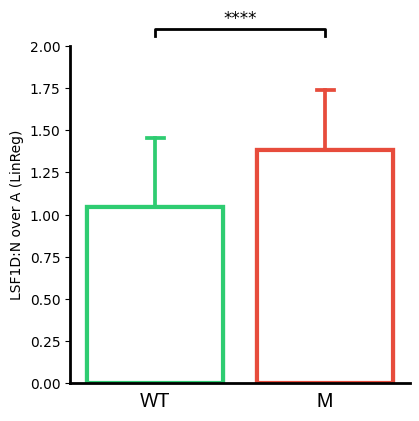

Label
Del38_46           198
Dup41_46           155
Mock               202
Mut394             124
No transfection    190
WT                 177
Name: LSF1D:RS, dtype: int64
                     Mean       Std   Std_Err
Label                                        
Del38_46         0.477383  0.047466  0.003373
Dup41_46         0.463435  0.045944  0.003690
Mock             0.483988  0.066470  0.004677
Mut394           0.481329  0.055886  0.005019
No transfection  0.490972  0.066374  0.004815
WT               0.495649  0.069688  0.005238
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Del38_46: Welch's t-test independent samples, P_val=3.624e-03 stat=2.932e+00


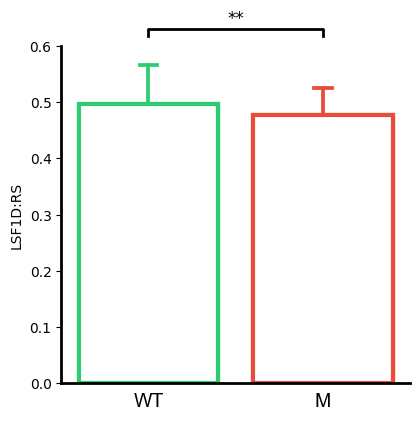

Label
Del38_46           198
Dup41_46           155
Mock               202
Mut394             124
No transfection    190
WT                 177
Name: LSF1D:Number of Lines (LinReg), dtype: int64
                       Mean         Std    Std_Err
Label                                             
Del38_46         108.767677   53.756327   3.820296
Dup41_46         215.206452  139.303914  11.189160
Mock             149.856436   81.386518   5.726335
Mut394           218.096774  161.192730  14.475534
No transfection  222.321053  155.869492  11.307961
WT               173.954802  162.248891  12.195373
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Del38_46: Welch's t-test independent samples, P_val=7.534e-07 stat=5.101e+00


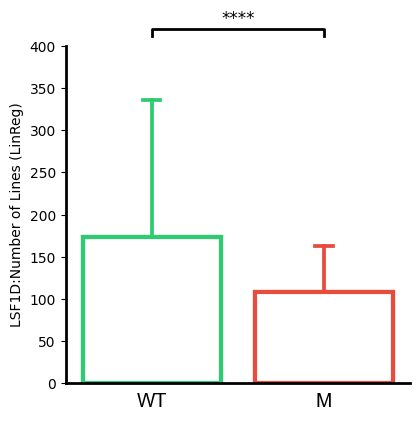

Label
Del38_46           198
Dup41_46           155
Mock               202
Mut394             124
No transfection    190
WT                 177
Name: SKNW:Number of Branches, dtype: int64
                       Mean         Std    Std_Err
Label                                             
Del38_46         115.828283   62.637956   4.451486
Dup41_46         212.941935  137.134082  11.014875
Mock             161.801980   83.426915   5.869897
Mut394           228.032258  170.949283  15.351699
No transfection  220.105263  150.409738  10.911869
WT               187.299435  155.098340  11.657905
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Del38_46: Welch's t-test independent samples, P_val=3.220e-08 stat=5.727e+00


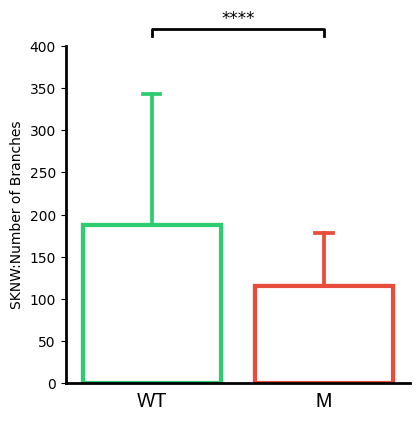

Label
Del38_46           198
Dup41_46           155
Mock               202
Mut394             124
No transfection    190
WT                 177
Name: DCF:AFI, dtype: int64
                        Mean         Std    Std_Err
Label                                              
Del38_46         3389.509241  414.028467  29.423722
Dup41_46         4070.438670  506.898251  40.715047
Mock             3171.489720  572.549071  40.284412
Mut394           3942.969293  486.057348  43.649238
No transfection  3644.879856  452.037789  32.794268
WT               3576.572800  728.593033  54.764406
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Del38_46: Welch's t-test independent samples, P_val=2.867e-03 stat=3.009e+00


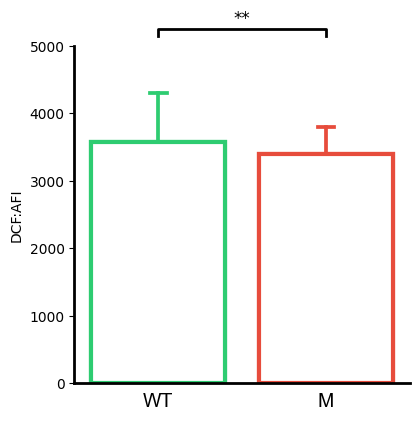

Label
Del38_46           198
Dup41_46           155
Mock               202
Mut394             124
No transfection    190
WT                 177
Name: LSF1D:RS NucCent Distance (LinReg) (scaled), dtype: int64
                      Mean        Std   Std_Err
Label                                          
Del38_46          6.745361   4.309156  0.306238
Dup41_46          9.232459   7.799116  0.626440
Mock              8.980485   6.364186  0.447783
Mut394           12.476383  18.330938  1.646167
No transfection  11.723918   8.161209  0.592076
WT               10.256862   7.519979  0.565236
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Del38_46: Welch's t-test independent samples, P_val=1.057e-07 stat=5.462e+00


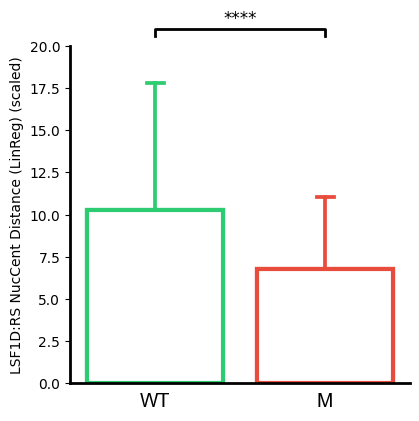

Label
Del38_46           198
Dup41_46           155
Mock               202
Mut394             124
No transfection    190
WT                 177
Name: DCF:AreaRatio 6, dtype: int64
                     Mean       Std   Std_Err
Label                                        
Del38_46         0.901784  0.332097  0.023601
Dup41_46         0.676480  0.320912  0.025776
Mock             0.905264  0.367689  0.025871
Mut394           0.704247  0.340465  0.030575
No transfection  0.673540  0.311193  0.022576
WT               0.596471  0.155889  0.011717
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Del38_46: Welch's t-test independent samples, P_val=1.016e-25 stat=-1.159e+01


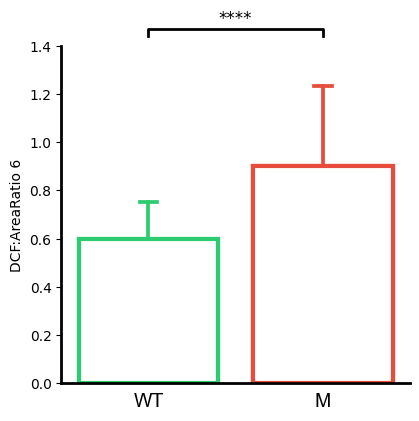

In [8]:
plot_barplot_paper(ResultsDF,
                   feature = [
                               'LSF1D:OOP (LinReg)',
                               'LSF1D:Circular Variance (LinReg)',
                               'LSF1D:Line Lengths (LinReg) mean',
                               'SKNW:branch-distance (scaled) mean',
                               'SKNW:branch-distance (scaled) cv',
                               'LSF1D:N over A (LinReg)',
                               'LSF1D:RS',
                               'LSF1D:Number of Lines (LinReg)',
                               'SKNW:Number of Branches',
                               'DCF:AFI',
                               'LSF1D:RS NucCent Distance (LinReg) (scaled)',
                               'DCF:AreaRatio 6',
                              ])

In [10]:
ResultsDF['SKNW:branch-distance (scaled) cv'] = ResultsDF['SKNW:branch-distance (scaled) std_dev'] / ResultsDF['SKNW:branch-distance (scaled) mean']

In [27]:
ResultsDF['Lines LinReg'].loc[1]

[((1183.139, 573.819), (1185.861, 575.181)),
 ((1187.94, 574.04), (1186.229, 575.181)),
 ((1186.0, 575.04), (1186.0, 575.96)),
 ((1173.74, 575.776), (1171.033, 577.903)),
 ((1184.964, 575.565), (1179.342, 586.592)),
 ((1186.17, 575.957), (1188.178, 578.826)),
 ((1169.75, 576.425), (1159.745, 583.488)),
 ((1170.725, 578.217), (1173.015, 582.933)),
 ((1206.0, 578.043), (1206.0, 580.957)),
 ((1213.957, 579.043), (1211.043, 581.957)),
 ((1206.179, 580.893), (1210.704, 582.401)),
 ((1150.055, 580.191), (1142.626, 586.559)),
 ((1199.139, 579.819), (1201.861, 581.181)),
 ((1202.0, 581.0), (1206.0, 581.0)),
 ((1202.0, 581.043), (1202.0, 583.957)),
 ((1177.729, 581.635), (1175.08, 582.96)),
 ((1173.0, 583.0), (1175.0, 583.0)),
 ((1172.97, 583.097), (1169.243, 585.184)),
 ((1174.717, 583.385), (1179.391, 587.599)),
 ((1159.214, 583.334), (1150.859, 591.763)),
 ((1162.791, 586.324), (1148.105, 604.686)),
 ((1141.04, 585.04), (1141.96, 585.96)),
 ((1142.0, 586.057), (1142.0, 587.943)),
 ((1215.321

In [55]:
res = []

for cell in ResultsDF['Lines LinReg']:
    cell_lens = []
    for line in cell:
        cell_lens += [np.linalg.norm((line[1][0] - line[0][0],line[1][1] - line[0][1])) * (0.16125)]
    res += [cell_lens]

ResultsDF['LSF1D:Line Lengths (LinReg)'] = res

In [56]:
ResultsDF['LSF1D:Line Lengths (LinReg)'] = [np.mean(a) for a in ResultsDF['LSF1D: Lines Lengths (LinReg)']]

                     Mean       Std   Std_Err
Label                                        
Del38_46         0.872430  0.097067  0.006898
Dup41_46         0.869543  0.072111  0.005792
Mock             0.913360  0.120431  0.008474
Mut394           0.863262  0.087610  0.007868
No transfection  0.891655  0.094266  0.006839
WT               0.979647  0.159734  0.012006
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Del38_46: t-test independent samples, P_val=2.304e-14 stat=7.946e+00


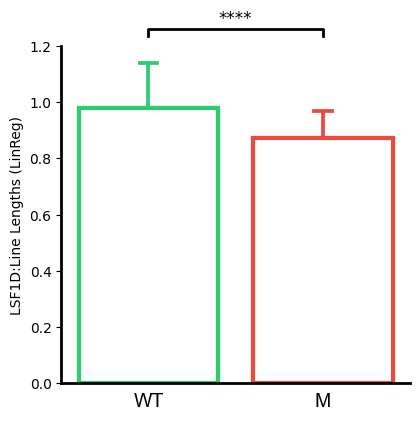

In [57]:
plot_barplot_paper(ResultsDF,
                   feature = [
                               
                               'LSF1D:Line Lengths (LinReg)'
                               
                              ])

In [75]:
for i in range(len(ResultsDF)):
    print(np.max(ResultsDF.loc[i]['Patches'][1]))

0.8105439841306172
0.8884565499351491
0.8105439841306172
0.8718852521553369
0.7960173952849622
0.8002594033722439
0.8052643625543603
0.9893797207598993
0.8284275577935455
0.8329137102311742
0.8767071030746929
0.8904097047379262
0.9102464332036316
0.9139696345464255
1.0
0.9980773632410163
0.994171053635462
0.7908598458838788
0.8400244144350347
0.9431448844129091
0.9357900358587015
0.8459754329747463
0.9862973983367667
0.8790569924467841
0.9756160830090791
0.8666666666666667
0.8959945067521172
0.8612344548714428
0.9765621423666743
0.9215991454947737
0.858304722667277
0.9073777370870527
0.9674982833600366
0.9480888075074387
0.8872358281834134
0.6823682001983673
0.9963378347447929
0.8833600366216525
0.9556572823682002
0.9592278934920272
0.9969787136644541
0.9757991912718395
0.9221179522392615
0.8941023880369269
0.948577096208133
0.9891355764095522
0.9884946974898909
0.871274891279469
0.6708934157320515
0.902037079423209
0.9449149309529259
0.8689555199511712
0.8224460212100404
0.98458838788

0.8868696116578927
0.7607385366598001
0.5931944762340734
0.6411383230334936
0.6896925307087816
0.604119935912108
0.6789806973373007
0.6803540093080034
0.5894712748912795
0.8051728084229801
0.8160372320134279
0.98803692683299
0.6784008545052262
0.6708628976882581
0.7197833218890669
0.7417868314641032
0.8586099031052109
0.8110627908751049
0.6441290913252461
0.7791103990234226
0.70766765850309
0.9023117418173495
0.669764248111696
0.9911802853437095
0.9898680094605936
0.9493095292591744
0.999298084992752
0.9049362935835813
0.983764400701915
0.9612420843823911
0.9283131151293202
0.9614251926451515
0.952849622339208
0.9162279697871366
0.9975280384527352
0.952849622339208
0.9992675669489586
0.9633478294041352
0.9168993667505912
0.9847104600595102
0.9951476310368506
0.9601129167620356
0.6772106507972839
0.9288929579613947
0.9839780270084687
0.9768978408484016
0.9067368581673915
0.8692301823453117
0.9419241626611734
0.8989547570000763
0.9552605477988861
0.986480506599527
0.9385061417563134
0.99

0.9550774395361258
0.9695429922941939
0.9722285801480125
0.9725642786297398
0.9996948195620661
0.9940794995040818
0.9134203097581445
0.956878004119936
0.9608148317692836
0.929533836881056
0.9947508964675364
0.9842832074464026
0.9288624399176013
0.9342336156252384
0.9342336156252384
0.9462272068360418
0.9506828412298771
0.9268482490272374
0.9767452506294346
0.9252307927061876
0.9398489356832227
0.9006637674525063
0.9894407568474861
0.9865110246433204
0.9865110246433204
0.7403830014496071
0.8512550545510033
0.9332265201800565
0.585626001373312
0.9105210955977722
0.9364309147783627
0.7466392004272526
0.566674296177615
0.6039368276493476
0.7224383916990921
0.6346990157930876
1.0
0.7510032806897078
0.9306324864576181
0.6436713206683452
0.8530861371786068
0.8199435416189822
0.6351262684061951
0.6985427634088655
0.6741588464179447
0.6494392309452964
0.5809567406729229
0.9076218814373999
0.6540474555580987
0.7420004577706569
0.5970092317082475
0.726161593041886
0.7482566567483024


In [80]:
ResultsDF['DCF:AFI'] = ResultsDF['DCF:AAI'] * 1/0.16125**2
#ResultsDF['DCF:AFI'] = getAAI()

In [105]:
# AAI COMPUTATION LAST -> DEVIA SER DO SKELETON MAS JA VAI TARDE
res = []

for index,row in ResultsDF.iterrows():
    imog = row['Patches'][1]
    patch     = (255* imog / np.max(imog)).astype(np.uint8)
    
    patchno0  = patch[patch != 0].tolist()
    
    aga       = np.histogram(patchno0,bins=255)
    local_min = argrelextrema(aga[0], np.less)[0]
    sumh      = np.sum(aga[0][local_min[0]:local_min[-1]] * aga[1][local_min[0]:local_min[-1]]) / row['DCF:Area (scaled)']

    res += [sumh]
    
ResultsDF['DCF:AFI'] = res
    

Label
Del38_46           198
Dup41_46           155
Mock               202
Mut394             124
No transfection    190
WT                 177
Name: DCF:AFI, dtype: int64
                        Mean         Std    Std_Err
Label                                              
Del38_46         3389.509241  414.028467  29.423722
Dup41_46         4070.438670  506.898251  40.715047
Mock             3171.489720  572.549071  40.284412
Mut394           3942.969293  486.057348  43.649238
No transfection  3644.879856  452.037789  32.794268
WT               3576.572800  728.593033  54.764406
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Del38_46: Welch's t-test independent samples, P_val=2.867e-03 stat=3.009e+00


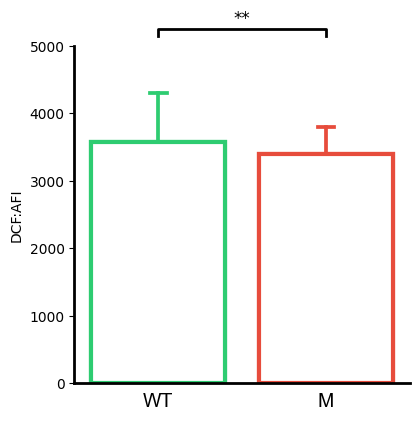

In [7]:
plot_barplot_paper(ResultsDF,
                   feature = [
                               
                               'DCF:AFI'
                               
                              ])

In [6]:
# DELETE AFTER

def getskelfrom(ResultsRow):
    idx = ResultsRow['Img Index']
    image = data['CYTO_PRE'].loc[idx]['Skeleton'] * retrieve_mask(ResultsRow['Mask'],ResultsRow['Image Size'])
    
    non_zero_indices = np.where((image*1)!=0)
    
    return non_zero_indices

def centroid_find(ResultsRow,CentroidsDF):
    x_,y_   = ResultsRow['Mask']
    imgIndex = ResultsRow['Img Index']
    df = CentroidsDF[imgIndex]
    # Find centroid
    for index,row in df.iterrows():
        if (round(row['Centroid'][0]),round(row['Centroid'][1])) in list(zip(x_,y_)):
            centroid = (row['Centroid'][0],row['Centroid'][1])
            contour  = row['Contour'][0][:,0]
            
            break
    try:
        centroid
    except:
        centroid = (0,0)
        contour = (0,0)
        print(index,'centroid not found. set to (0,0)')
        
    return centroid,contour




data['NUCL_PRE'] = pd.read_pickle(folder + "\\NUCL_PRE\\NUCL_PRE.pkl") # pd.read_pickle(os.getcwd() + "\\NUCL_PRE_2D_StarDist.pkl") #
data['CYTO_PRE'] = pd.read_pickle(folder + "\\CYTO_PRE\\CYTO_PRE.pkl")
CentroidsDF      = pickle.load(open(folder + '//Centroids.p', 'rb'))
ResultsDF        = pd.read_pickle(folder + "\\ResultsDF_9_jan_24.pkl")
ResultsDF['Mask'] = [np.where((mask*1)!=0) for mask in ResultsDF['Mask']]
ResultsDF['Resolution'] =  [(1, 0.16125,0.16125) for i in range(len(ResultsDF))]
ResultsDF['Image Size'] = [(1040, 1388) for i in range(len(ResultsDF))]
ResultsDF['Skeleton'] = [getskelfrom(row) for index,row in ResultsDF.iterrows()]
ResultsDF['Nucleus Centroid'] = [centroid_find(row,CentroidsDF)[0] for index,row in ResultsDF.iterrows()]
ResultsDF['Nucleus Contour'] = [centroid_find(row,CentroidsDF)[1] for index,row in ResultsDF.iterrows()]
ResultsDF['Lines'] = ResultsDF['Lines LinReg']

70 centroid not found. set to (0,0)
70 centroid not found. set to (0,0)
70 centroid not found. set to (0,0)
70 centroid not found. set to (0,0)


In [108]:
ResultsDF.to_pickle(folder + '//ResultsDF_7_nov_24_totest.pkl')   
ResultsDF.to_excel(folder + "//ResultsDF_7_nov_24_totest.xlsx") 

Label
Del38_46           198
Dup41_46           155
Mock               202
Mut394             124
No transfection    190
WT                 177
Name: LSF1D:OOP (LinReg), dtype: int64
                     Mean       Std   Std_Err
Label                                        
Del38_46         0.079481  0.048040  0.003414
Dup41_46         0.069767  0.038487  0.003091
Mock             0.094461  0.059924  0.004216
Mut394           0.093900  0.051804  0.004652
No transfection  0.086332  0.051154  0.003711
WT               0.128594  0.098935  0.007436
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Del38_46: Welch's t-test independent samples, P_val=6.868e-09 stat=6.002e+00


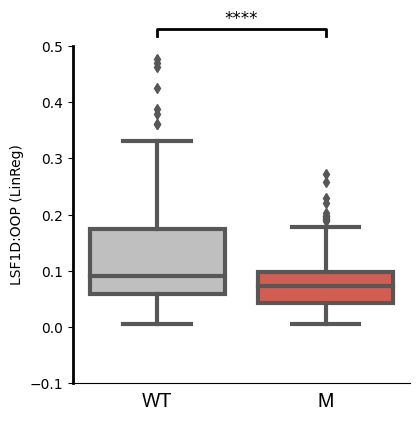

Label
Del38_46           198
Dup41_46           155
Mock               202
Mut394             124
No transfection    190
WT                 177
Name: LSF1D:Circular Variance (LinReg), dtype: int64
                     Mean       Std   Std_Err
Label                                        
Del38_46         0.920519  0.048040  0.003414
Dup41_46         0.930233  0.038487  0.003091
Mock             0.905539  0.059924  0.004216
Mut394           0.906100  0.051804  0.004652
No transfection  0.913668  0.051154  0.003711
WT               0.871406  0.098935  0.007436
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Del38_46: Welch's t-test independent samples, P_val=6.868e-09 stat=-6.002e+00


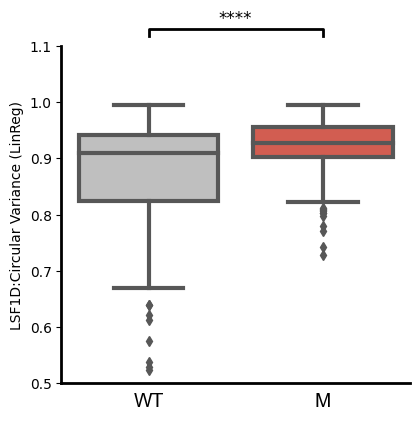

Label
Del38_46           198
Dup41_46           155
Mock               202
Mut394             124
No transfection    190
WT                 177
Name: LSF1D:Line Lengths (LinReg), dtype: int64
                     Mean       Std   Std_Err
Label                                        
Del38_46         0.872430  0.097067  0.006898
Dup41_46         0.869543  0.072111  0.005792
Mock             0.913360  0.120431  0.008474
Mut394           0.863262  0.087610  0.007868
No transfection  0.891655  0.094266  0.006839
WT               0.979647  0.159734  0.012006
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Del38_46: Welch's t-test independent samples, P_val=1.723e-13 stat=7.743e+00


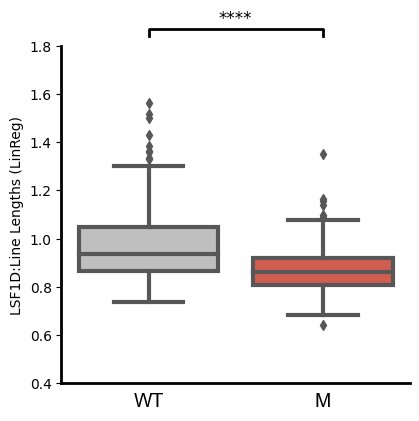

Label
Del38_46           198
Dup41_46           155
Mock               202
Mut394             124
No transfection    190
WT                 177
Name: SKNW:branch-distance (scaled) mean, dtype: int64
                     Mean       Std   Std_Err
Label                                        
Del38_46         1.023670  0.118302  0.008407
Dup41_46         1.011195  0.091961  0.007386
Mock             1.074065  0.148407  0.010442
Mut394           1.006441  0.104802  0.009411
No transfection  1.036373  0.115404  0.008372
WT               1.151957  0.196473  0.014768
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Del38_46: Welch's t-test independent samples, P_val=6.087e-13 stat=7.549e+00


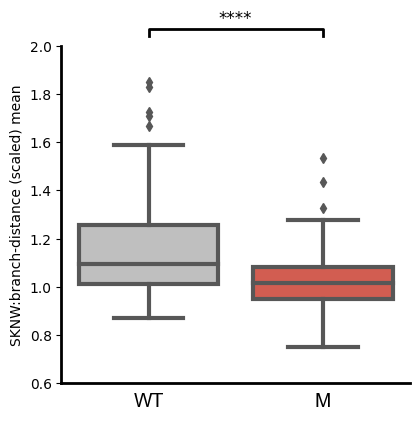

Label
Del38_46           198
Dup41_46           155
Mock               202
Mut394             124
No transfection    190
WT                 177
Name: SKNW:branch-distance (scaled) cv, dtype: int64
                     Mean       Std   Std_Err
Label                                        
Del38_46         0.824470  0.137939  0.009803
Dup41_46         0.828111  0.129582  0.010408
Mock             0.880246  0.152914  0.010759
Mut394           0.862895  0.118385  0.010631
No transfection  0.878381  0.153596  0.011143
WT               0.912204  0.159436  0.011984
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Del38_46: Welch's t-test independent samples, P_val=3.044e-08 stat=5.667e+00


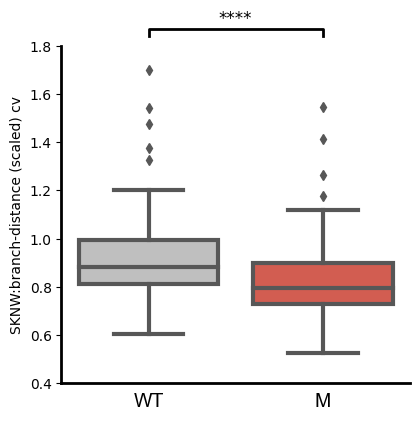

Label
Del38_46           198
Dup41_46           155
Mock               202
Mut394             124
No transfection    190
WT                 177
Name: LSF1D:N over A (LinReg), dtype: int64
                     Mean       Std   Std_Err
Label                                        
Del38_46         1.381324  0.356205  0.025314
Dup41_46         1.470359  0.224637  0.018043
Mock             1.626541  0.517069  0.036381
Mut394           1.466525  0.361264  0.032443
No transfection  1.449438  0.226729  0.016449
WT               1.045483  0.405742  0.030497
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Del38_46: Welch's t-test independent samples, P_val=6.570e-16 stat=-8.473e+00


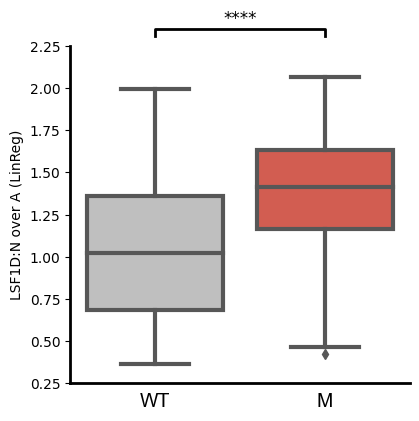

Label
Del38_46           198
Dup41_46           155
Mock               202
Mut394             124
No transfection    190
WT                 177
Name: LSF1D:RS, dtype: int64
                     Mean       Std   Std_Err
Label                                        
Del38_46         0.477383  0.047466  0.003373
Dup41_46         0.463435  0.045944  0.003690
Mock             0.483988  0.066470  0.004677
Mut394           0.481329  0.055886  0.005019
No transfection  0.490972  0.066374  0.004815
WT               0.495649  0.069688  0.005238
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Del38_46: Welch's t-test independent samples, P_val=3.624e-03 stat=2.932e+00


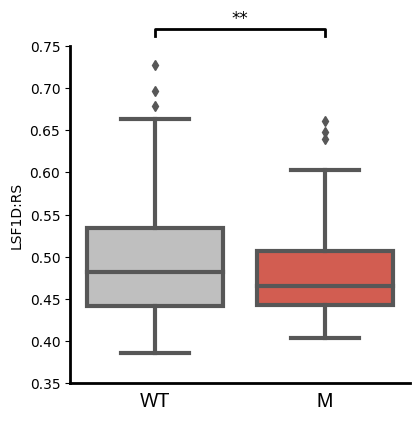

Label
Del38_46           198
Dup41_46           155
Mock               202
Mut394             124
No transfection    190
WT                 177
Name: LSF1D:Number of Lines (LinReg), dtype: int64
                       Mean         Std    Std_Err
Label                                             
Del38_46         108.767677   53.756327   3.820296
Dup41_46         215.206452  139.303914  11.189160
Mock             149.856436   81.386518   5.726335
Mut394           218.096774  161.192730  14.475534
No transfection  222.321053  155.869492  11.307961
WT               173.954802  162.248891  12.195373
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Del38_46: Welch's t-test independent samples, P_val=7.534e-07 stat=5.101e+00


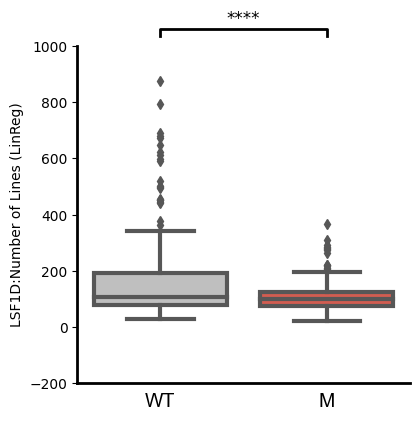

Label
Del38_46           198
Dup41_46           155
Mock               202
Mut394             124
No transfection    190
WT                 177
Name: SKNW:Number of Branches, dtype: int64
                       Mean         Std    Std_Err
Label                                             
Del38_46         115.828283   62.637956   4.451486
Dup41_46         212.941935  137.134082  11.014875
Mock             161.801980   83.426915   5.869897
Mut394           228.032258  170.949283  15.351699
No transfection  220.105263  150.409738  10.911869
WT               187.299435  155.098340  11.657905
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Del38_46: Welch's t-test independent samples, P_val=3.220e-08 stat=5.727e+00


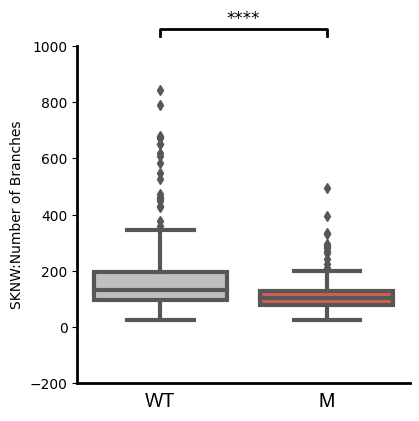

Label
Del38_46           198
Dup41_46           155
Mock               202
Mut394             124
No transfection    190
WT                 177
Name: DCF:AFI, dtype: int64
                        Mean         Std    Std_Err
Label                                              
Del38_46         3389.509241  414.028467  29.423722
Dup41_46         4070.438670  506.898251  40.715047
Mock             3171.489720  572.549071  40.284412
Mut394           3942.969293  486.057348  43.649238
No transfection  3644.879856  452.037789  32.794268
WT               3576.572800  728.593033  54.764406
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Del38_46: Welch's t-test independent samples, P_val=2.867e-03 stat=3.009e+00


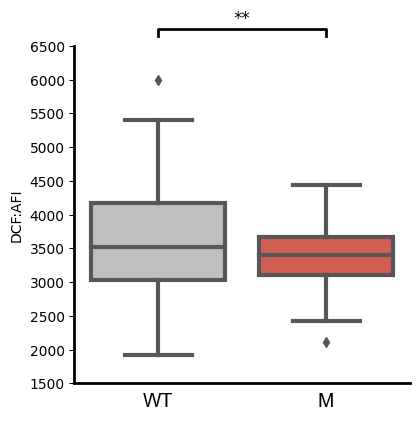

Label
Del38_46           198
Dup41_46           155
Mock               202
Mut394             124
No transfection    190
WT                 177
Name: LSF1D:RS NucCent Distance (LinReg) (scaled), dtype: int64
                      Mean        Std   Std_Err
Label                                          
Del38_46          6.745361   4.309156  0.306238
Dup41_46          9.232459   7.799116  0.626440
Mock              8.980485   6.364186  0.447783
Mut394           12.476383  18.330938  1.646167
No transfection  11.723918   8.161209  0.592076
WT               10.256862   7.519979  0.565236
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Del38_46: Welch's t-test independent samples, P_val=1.057e-07 stat=5.462e+00


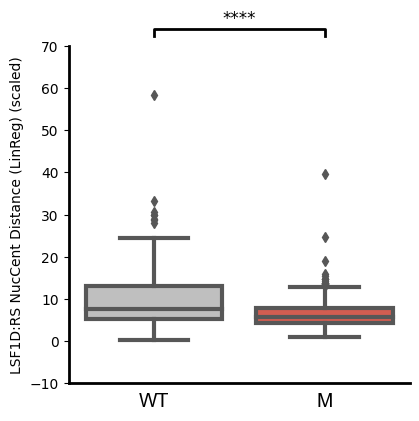

Label
Del38_46           198
Dup41_46           155
Mock               202
Mut394             124
No transfection    190
WT                 177
Name: DCF:AreaRatio 6, dtype: int64
                     Mean       Std   Std_Err
Label                                        
Del38_46         0.901784  0.332097  0.023601
Dup41_46         0.676480  0.320912  0.025776
Mock             0.905264  0.367689  0.025871
Mut394           0.704247  0.340465  0.030575
No transfection  0.673540  0.311193  0.022576
WT               0.596471  0.155889  0.011717
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. Del38_46: Welch's t-test independent samples, P_val=1.016e-25 stat=-1.159e+01


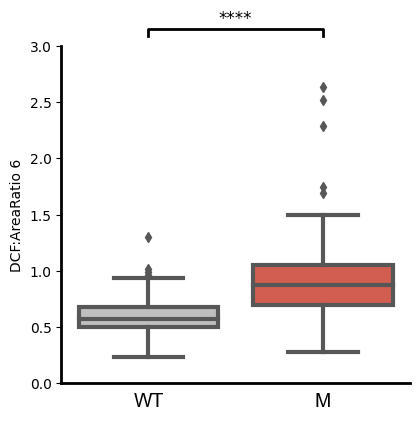

In [3]:
plot_boxplot_paper(ResultsDF,
                   feature = [
                               'LSF1D:OOP (LinReg)',
                               'LSF1D:Circular Variance (LinReg)',
                               'LSF1D:Line Lengths (LinReg)',
                               'SKNW:branch-distance (scaled) mean',
                               'SKNW:branch-distance (scaled) cv',
                               'LSF1D:N over A (LinReg)',
                               'LSF1D:RS',
                               'LSF1D:Number of Lines (LinReg)',
                               'SKNW:Number of Branches',
                               'DCF:AFI',
                               'LSF1D:RS NucCent Distance (LinReg) (scaled)',
                               'DCF:AreaRatio 6',
                              ])